In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pid_file = 'PID_Schedule_Job_20220509.xls'
prweb_file = 'New Production Status Summary 2022-05-18.xlsx'
cft_list_file = 'CFTListExport_2022-05-20-09-10-10-246.xls'

In [3]:
pid = pd.read_excel(pid_file, sheet_name='1_PID_Date', header=1)

In [4]:
pid = pid.iloc[:,:6]

In [5]:
# Remove whole schedule rows
# Select PDP project
# Remove Asia SKU
pid = pid[(pid['Phase Name']!='Whole Schedule') & (pid['Project type']=='PDP') & (~pid['Project Name'].str.contains('Asia|ASIA'))]

In [6]:
# Replace . in Phase start column
pid['Phase Start'] = pid['Phase Start'].apply(lambda date : np.nan if date == '.' else str(date))

In [7]:
pid.loc[:,'Phase Start'] = pd.to_datetime(pid['Phase Start'], format='%Y%m%d')

In [8]:
pid = pid.dropna()

In [9]:
pid.drop('Planner', axis=1, inplace=True)

In [10]:
cft = pd.read_excel(cft_list_file, usecols=[1,44])

In [11]:
cft.rename(columns={"Develop  Product QE (DPQE)":"DPQE"}, inplace=True)

In [12]:
mismatch = pd.merge(how='left',left=pid, right=cft, on='Project Name')

In [13]:
# Find projects didn't have DPQE in PM system
mismatch[mismatch['DPQE'].isnull()]['Project Name'].drop_duplicates().to_csv('No_DPQE_Projects.csv')

In [14]:
pid_cft = pd.merge(left=pid, right=cft, on='Project Name')

In [15]:
# Weight socre, Toplevel, WP, MP = 1, FP = 2, PR = 3
pid_cft['weighted_score'] = pid_cft['Phase Name'].apply(lambda phase : 1 if (phase == 'Working Proto') | (phase == 'TopLevelDesign') | (phase == 'Mass Production') else 2 if phase=='Factory Proto' else 3 if phase=='Pilot Run' else 0)

In [16]:
prweb = pd.read_excel(prweb_file, header=1)

In [40]:
multi_project = prweb.groupby(['PM Project Name']).count()['Project Name'].sort_values(ascending=False).reset_index().rename(columns={'Project Name':'Project counts'})
multi_project = multi_project[multi_project['Project counts']>1]
multi_project

,PM Project Name,Project counts
0,GPSMAP 9000,5
1,dezl OTR Series 2022,4
2,BMW MGU22,4
3,RV/Camper 2022,3
4,Catalyst Kart/Moto/Roadster,3
5,ECHOMAP UHD2 (Touch),3
6,Forerunner 265,2
7,TXTW22_Drive+3.0 (Lawrence DA & Taroko EB),2
8,Descent Mk3 Series,2
9,"RV Fixed Displays (7""/10"")",2


In [41]:
pid_cft_multi = pd.merge(how='left', left=pid_cft, right=multi_project, left_on='Project Name', right_on='PM Project Name')
pid_cft_multi['Project counts'].fillna(1, inplace=True)
pid_cft_multi


,Category,Project type,Project Name,Phase Name,Phase Start,DPQE,weighted_score,PM Project Name,Project counts
0,Fitness,PDP,2022 vivofit jr. 3 SKUs,Factory Proto,2022-01-19,"Fu, Ernest",2,NaN,1.0
1,Fitness,PDP,2022 vivofit jr. 3 SKUs,Pilot Run,2022-03-04,"Fu, Ernest",3,NaN,1.0
2,Fitness,PDP,2022 vivofit jr. 3 SKUs,Mass Production,2022-04-25,"Fu, Ernest",1,NaN,1.0
3,OEM Auto,PDP,All_Garmin_meter,Mass Production,2022-05-30,NaN,1,NaN,1.0
4,Outdoor,PDP,Alpha Dog Collar,TopLevelDesign,2021-04-12,"Kuo, Chris",1,NaN,1.0
...,...,...,...,...,...,...,...,...,...
367,Automotive,PDP,zumo XT2,TopLevelDesign,2021-12-16,"Ni, Wendy",1,NaN,1.0
368,Automotive,PDP,zumo XT2,Working Proto,2022-05-11,"Ni, Wendy",1,NaN,1.0
369,Automotive,PDP,zumo XT2,Factory Proto,2022-08-26,"Ni, Wendy",2,NaN,1.0
370,Automotive,PDP,zumo XT2,Pilot Run,2022-11-21,"Ni, Wendy",3,NaN,1.0


In [42]:
pid_cft_multi['weighted_score_multi projects'] = pid_cft_multi['weighted_score']*pid_cft_multi['Project counts']

In [43]:
pid_cft_multi

,Category,Project type,Project Name,Phase Name,Phase Start,DPQE,weighted_score,PM Project Name,Project counts,weighted_score_multi projects
0,Fitness,PDP,2022 vivofit jr. 3 SKUs,Factory Proto,2022-01-19,"Fu, Ernest",2,NaN,1.0,2.0
1,Fitness,PDP,2022 vivofit jr. 3 SKUs,Pilot Run,2022-03-04,"Fu, Ernest",3,NaN,1.0,3.0
2,Fitness,PDP,2022 vivofit jr. 3 SKUs,Mass Production,2022-04-25,"Fu, Ernest",1,NaN,1.0,1.0
3,OEM Auto,PDP,All_Garmin_meter,Mass Production,2022-05-30,NaN,1,NaN,1.0,1.0
4,Outdoor,PDP,Alpha Dog Collar,TopLevelDesign,2021-04-12,"Kuo, Chris",1,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
367,Automotive,PDP,zumo XT2,TopLevelDesign,2021-12-16,"Ni, Wendy",1,NaN,1.0,1.0
368,Automotive,PDP,zumo XT2,Working Proto,2022-05-11,"Ni, Wendy",1,NaN,1.0,1.0
369,Automotive,PDP,zumo XT2,Factory Proto,2022-08-26,"Ni, Wendy",2,NaN,1.0,2.0
370,Automotive,PDP,zumo XT2,Pilot Run,2022-11-21,"Ni, Wendy",3,NaN,1.0,3.0


In [21]:
# Handle projects with multiple GMLAs but share same PID schedule

#def multi_gmla_product(Project_Name,weighted_score):
#    if Project_Name == 'GPSMAP 9000':
#        return weighted_score*3 #4 GMLAs, 1 GPSMAP 9000, 19" assign to Evelyn Wang
#    elif Project_Name == 'ECHOMAP UHD2 (Keyed)':
#        return weighted_score*2 #2 GMLAs
#    elif Project_Name == 'ECHOMAP UHD2 (Touch)':
#        return weighted_score*3 #3 GMLAs
#    elif Project_Name == 'dezl OTR Series 2022':
#        return weighted_score*4 #4 GMLAs
#    elif Project_Name == 'Catalyst Kart/Moto/Roadster':
#        return weighted_score*3 #3 GMLAs
#    else:
#        return weighted_score

In [22]:
#pid_cft['weighted_score']=np.vectorize(multi_gmla_product)(pid_cft['Project Name'], pid_cft['weighted_score'])

In [44]:
# Set date format for heatmap
pid_cft_multi['Date']=pid_cft_multi['Phase Start'].dt.strftime('%Y-%m')

In [45]:
pid_cft_multi = pid_cft_multi[pid_cft_multi['Date'] > '2022-01']

In [46]:
consumer_dpqe_list = ['Lo, Aalto','Kuo, Chris','Wang, Cooper', 'Fu, Ernest','Fu, Ernest;\nLo, Aalto','Hsu, Jason(PQE)','Ni, Wendy']

In [47]:
# Assign dataframe to df_consumer_dpqe
df_consumer_dpqe = pid_cft_multi[pid_cft_multi['DPQE'].isin(consumer_dpqe_list)]

In [48]:
#Output
df_consumer_dpqe.groupby(['DPQE','Date']).agg({'weighted_score_multi projects':'sum', 'Project counts':'count'}).unstack(level=0).transpose().to_excel('score_and_count.xlsx')

In [33]:
df_consumer_dpqe.groupby(['DPQE','Date']).count()

Category  Project type  Project Name  Phase Name  \
DPQE         Date                                                        
Fu, Ernest   2022-03         1             1             1           1   
             2022-04         2             2             2           2   
             2022-06         3             3             3           3   
             2022-08         1             1             1           1   
             2022-09         1             1             1           1   
...                        ...           ...           ...         ...   
Wang, Cooper 2023-06         1             1             1           1   
             2023-07         1             1             1           1   
             2023-08         2             2             2           2   
             2023-09         1             1             1           1   
             2023-10         1             1             1           1   

                      Phase Start  weighted_score  PM Project Name  \
DPQE         Date                                                    
Fu, Ernest   2022-03            1               1                0   
             2022-04            2               2                0   
             2022-06            3               3                1   
             2022-08            1               1                0   
             2022-09            1               1                1   
...                           ...             ...              ...   
Wang, Cooper 2023-06            1               1                0   
             2023-07            1               1                0   
             2023-08            2               2                0   
             2023-09            1               1                0   
             2023-10            1               1                0   

                      Project counts  weighted_score_counts  
DPQE         Date                                            
Fu, Ernest   2022-03               1                      1  
             2022-04               2                      2  
             2022-06               3                      3  
             2022-08               1                      1  
             2022-09               1                      1  
...                              ...                    ...  
Wang, Cooper 2023-06               1                      1  
             2023-07               1                      1  
             2023-08               2                      2  
             2023-09               1                      1  
             2023-10               1                      1  

[85 rows x 9 columns]

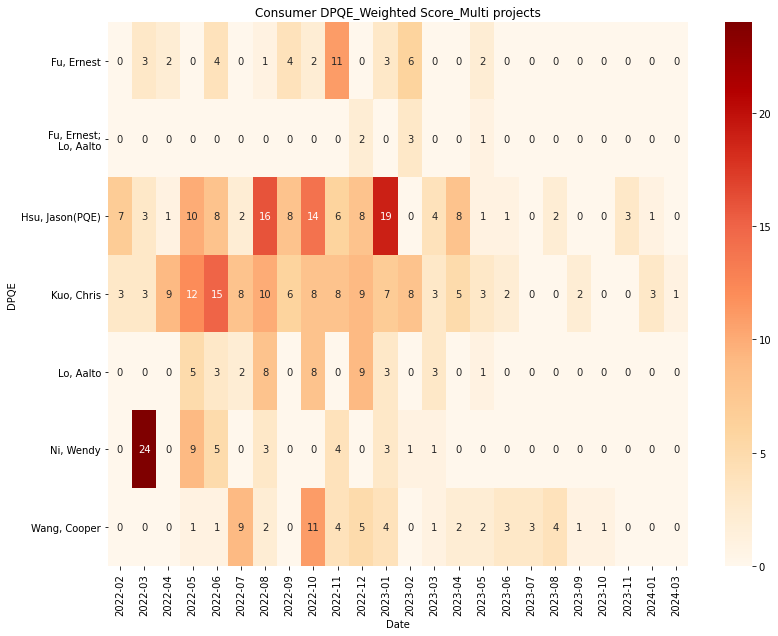

In [49]:
plt.figure(figsize=(13,10))
sns.heatmap(df_consumer_dpqe.groupby(['DPQE','Date']).sum()['weighted_score_multi projects'].unstack(fill_value=0),cmap="OrRd", annot=True).set(title='Consumer DPQE_Weighted Score_Multi projects');
#plt.savefig('Consumer DPQE',bbox_inches = "tight")

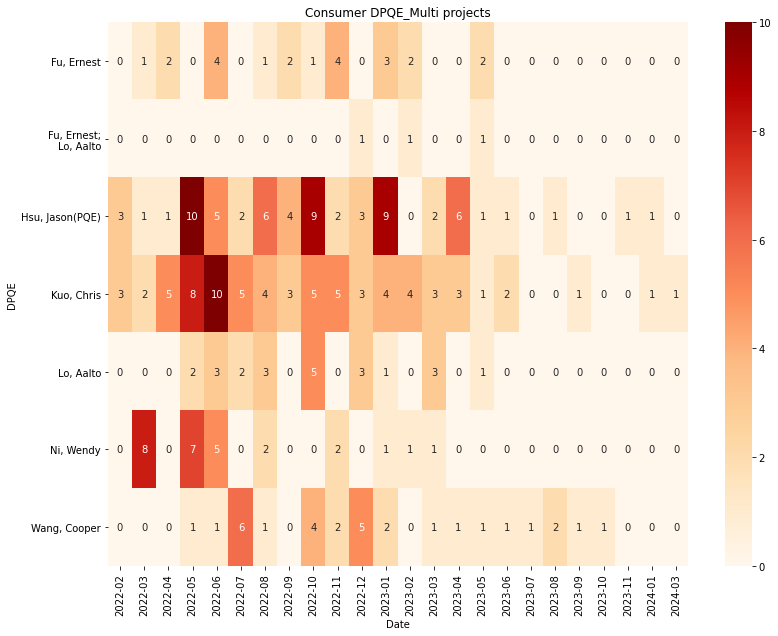

In [54]:
plt.figure(figsize=(13,10))
sns.heatmap(df_consumer_dpqe.groupby(['DPQE','Date']).sum()['Project counts'].unstack(fill_value=0),cmap="OrRd", annot=True).set(title='Consumer DPQE_Multi projects');

In [52]:
df_consumer_dpqe_project = df_consumer_dpqe.groupby(['DPQE','Date','Project Name']).sum().sort_index()
df_consumer_dpqe_project

weighted_score  \
DPQE         Date    Project Name                                   
Fu, Ernest   2022-03 2022 vivofit jr. 3 SKUs                    3   
             2022-04 2022 vivofit jr. 3 SKUs                    1   
                     Forerunner 955 and 955 Solar               1   
             2022-06 Forerunner 255 Small                       1   
                     Forerunner 265                             1   
...                                                           ...   
Wang, Cooper 2023-07 Descent Mk3s                               3   
             2023-08 Descent Mk3                                3   
                     Enduro 2023                                1   
             2023-09 Descent Mk3s                               1   
             2023-10 Descent Mk3                                1   

                                                   Project counts  \
DPQE         Date    Project Name                                   
Fu, Ernest   2022-03 2022 vivofit jr. 3 SKUs                  1.0   
             2022-04 2022 vivofit jr. 3 SKUs                  1.0   
                     Forerunner 955 and 955 Solar             1.0   
             2022-06 Forerunner 255 Small                     1.0   
                     Forerunner 265                           2.0   
...                                                           ...   
Wang, Cooper 2023-07 Descent Mk3s                             1.0   
             2023-08 Descent Mk3                              1.0   
                     Enduro 2023                              1.0   
             2023-09 Descent Mk3s                             1.0   
             2023-10 Descent Mk3                              1.0   

                                                   weighted_score_multi projects  
DPQE         Date    Project Name                                                 
Fu, Ernest   2022-03 2022 vivofit jr. 3 SKUs                                 3.0  
             2022-04 2022 vivofit jr. 3 SKUs                                 1.0  
                     Forerunner 955 and 955 Solar                            1.0  
             2022-06 Forerunner 255 Small                                    1.0  
                     Forerunner 265                                          2.0  
...                                                                          ...  
Wang, Cooper 2023-07 Descent Mk3s                                            3.0  
             2023-08 Descent Mk3                                             3.0  
                     Enduro 2023                                             1.0  
             2023-09 Descent Mk3s                                            1.0  
             2023-10 Descent Mk3                                             1.0  

[193 rows x 3 columns]

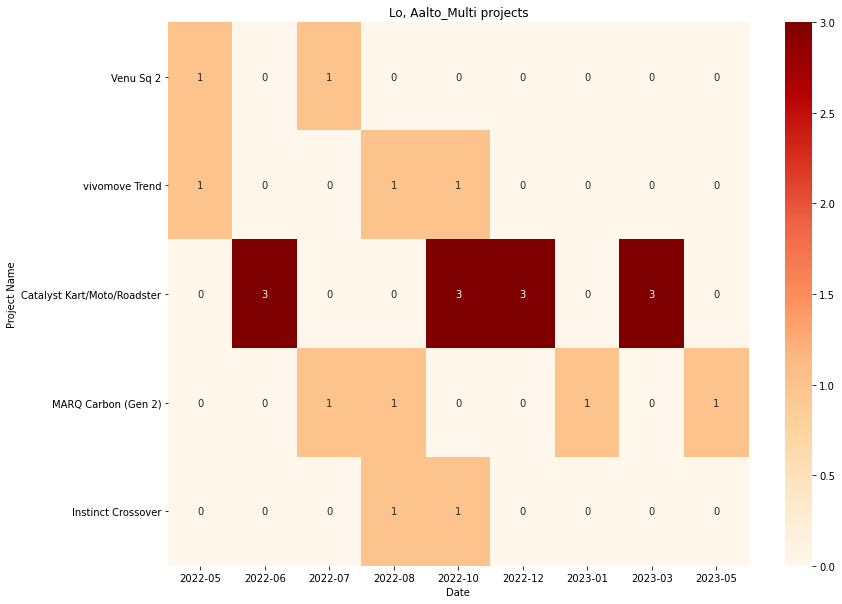

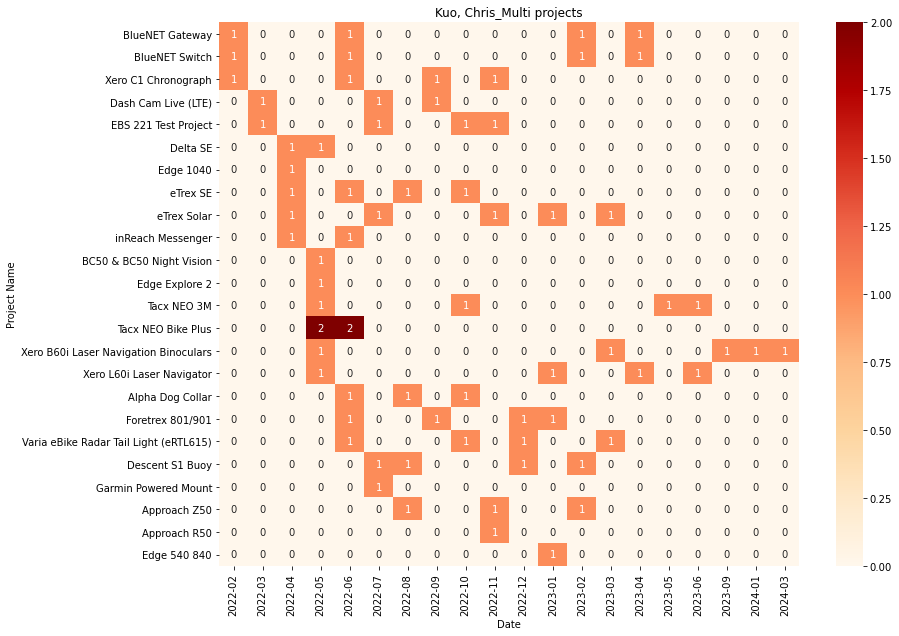

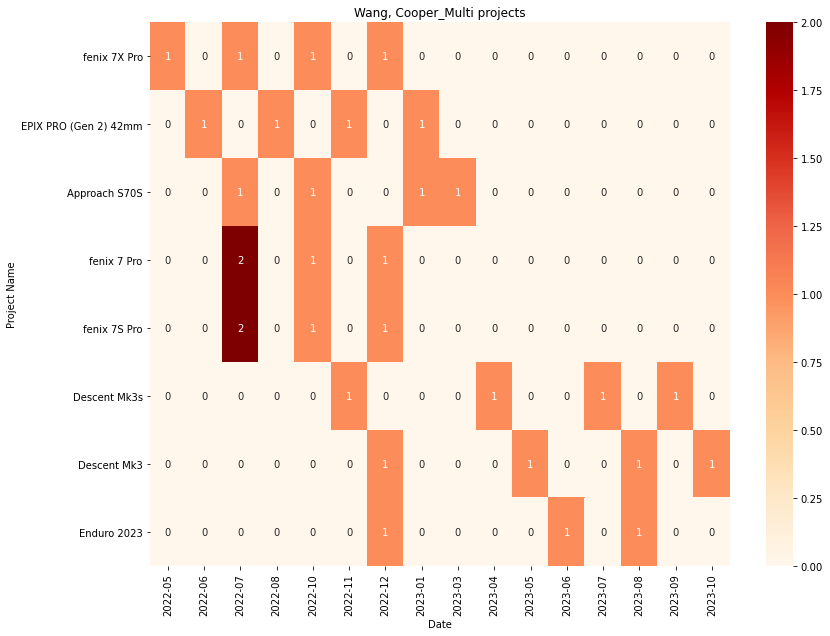

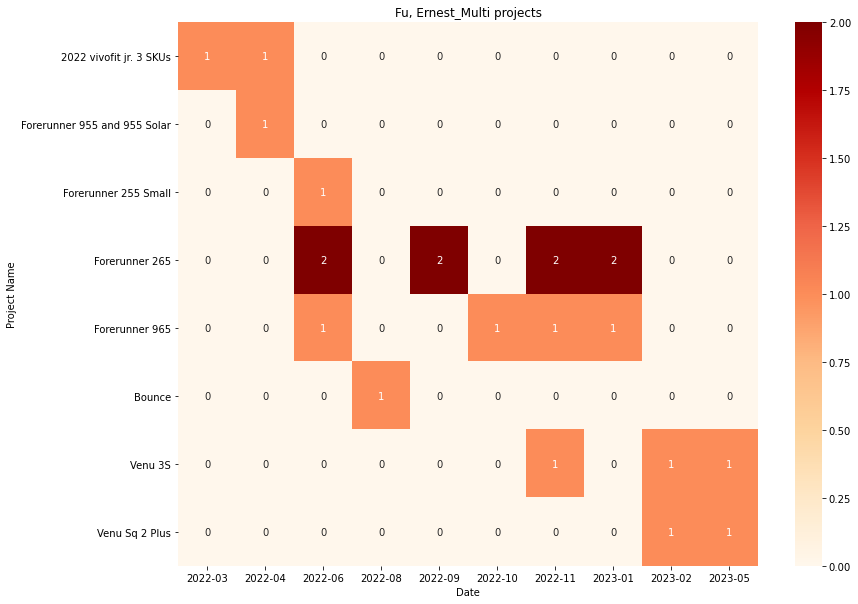

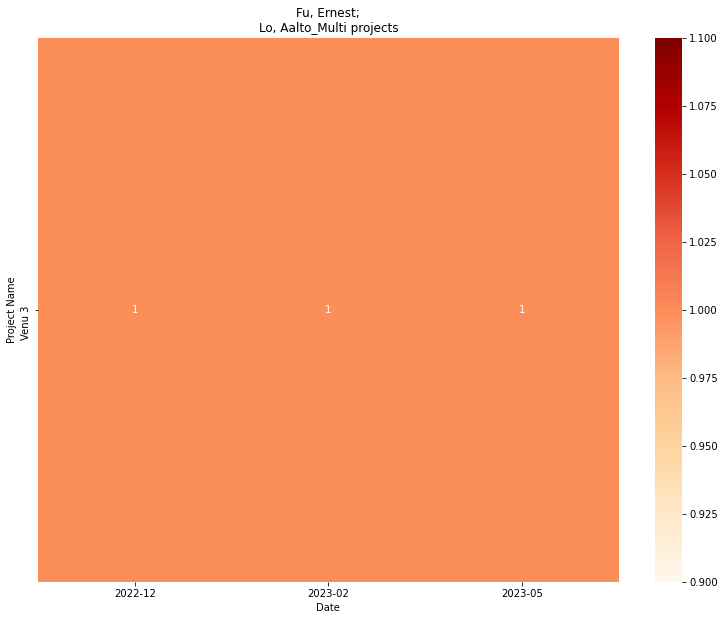

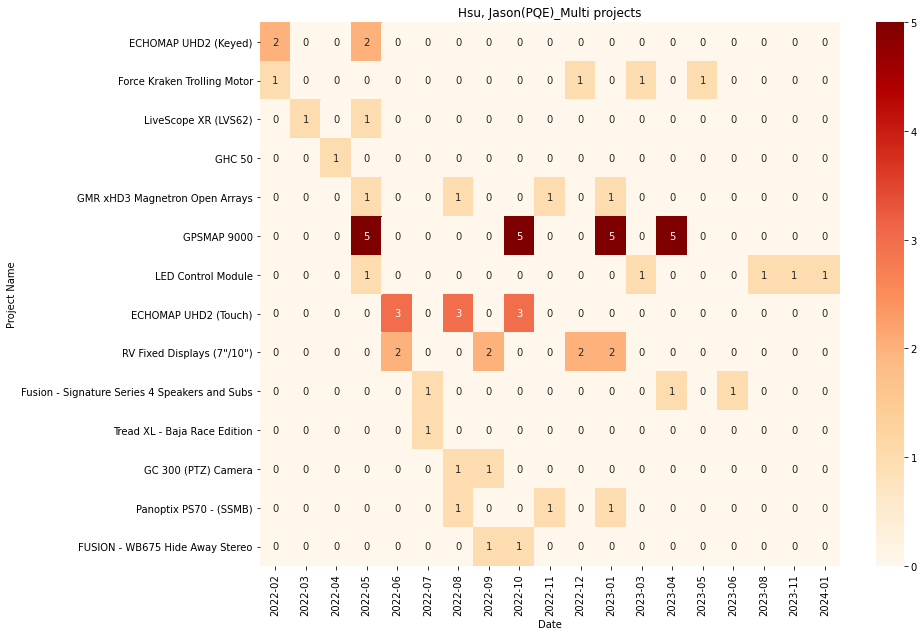

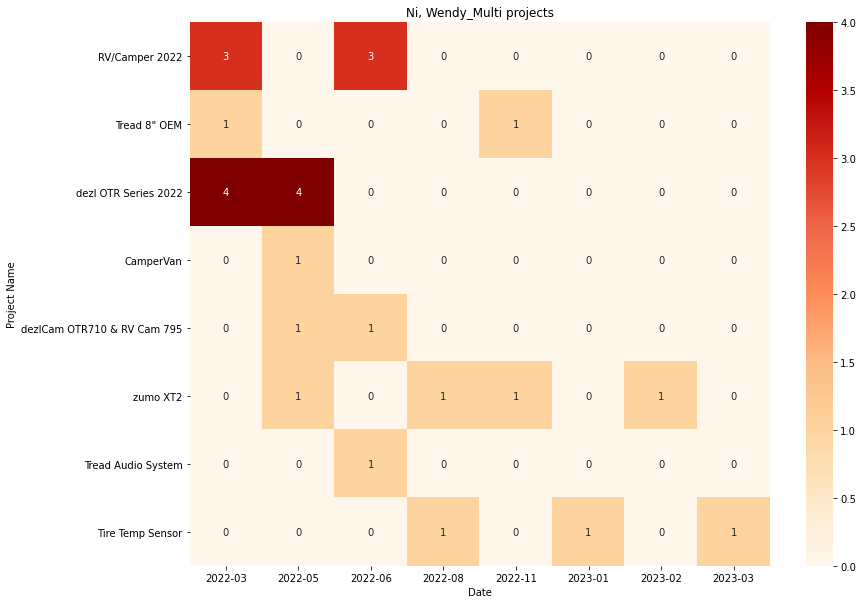

In [56]:
for member in consumer_dpqe_list:
    plt.figure(figsize=(13,10))
    sns.heatmap(df_consumer_dpqe_project.loc[member]['Project counts'].unstack(fill_value=0,level=0),cmap="OrRd", annot=True).set(title=member+'_Multi projects');

In [180]:
#plt.figure(figsize=(20,30))
#sns.heatmap(df_consumer_dpqe_project.unstack(level=1)['weighted_score'],cmap="OrRd", annot=True,linewidths=0.5, linecolor='orange');

In [181]:
#df_consumer_dpqe_project.unstack(level=1)['weighted_score'].to_excel('overall.xlsx')